In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Flatten, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model


In [2]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

In [3]:
file = open("WISDM_ar_v1.1_raw.txt")
lines=file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(",")
        last = line[5].split(";")[0]
        #last = last.replace(";","")
        last = last.strip()
        if last == "":
            break;
        temp = [line[0], line[1], line[2], line[3], line[4],last]
        processedList.append(temp)
    except:
        print("Error at line number: ", i)


Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [4]:
columns = ['user','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']


In [5]:
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user       343416 non-null  object
 1   activity   343416 non-null  object
 2   timestamp  343416 non-null  object
 3   x-axis     343416 non-null  object
 4   y-axis     343416 non-null  object
 5   z-axis     343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB


# Exploration

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

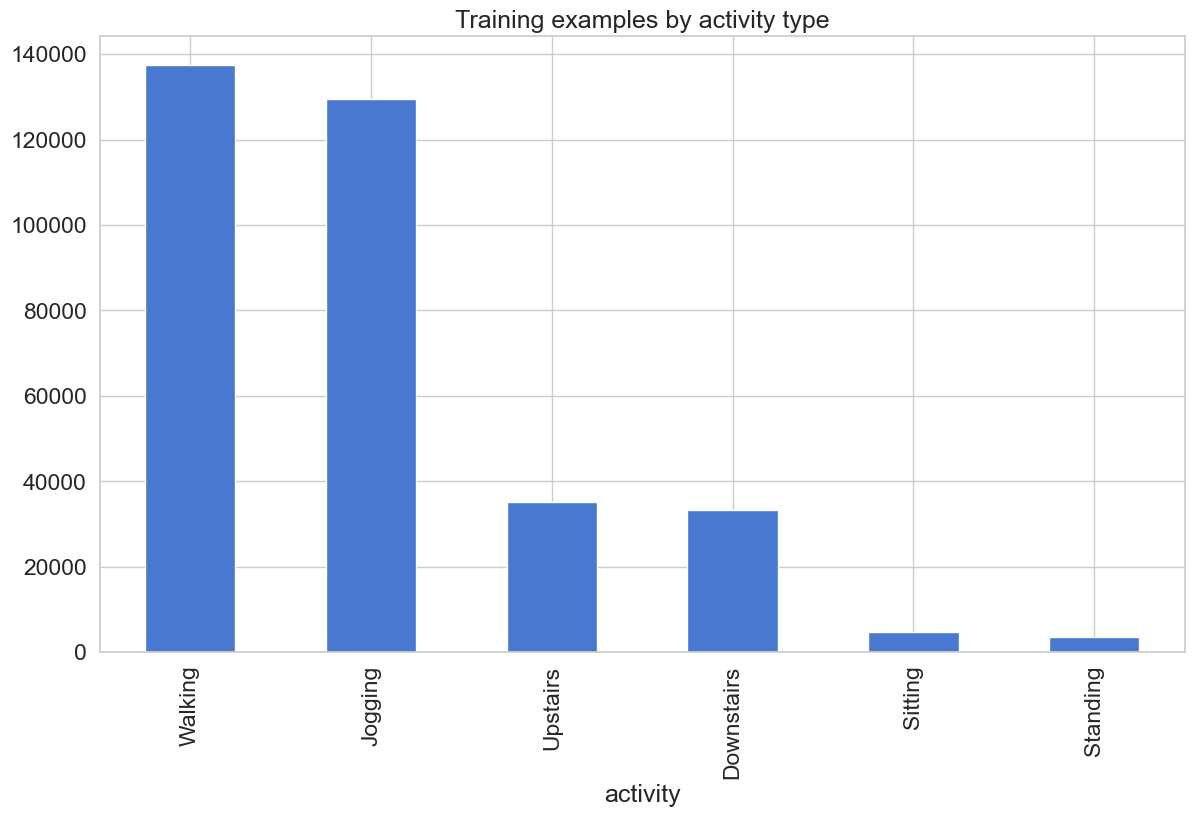

In [7]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

The columns we will be most interested in are activity, x-axis, y-axis and z-axis. Let's dive into the data:

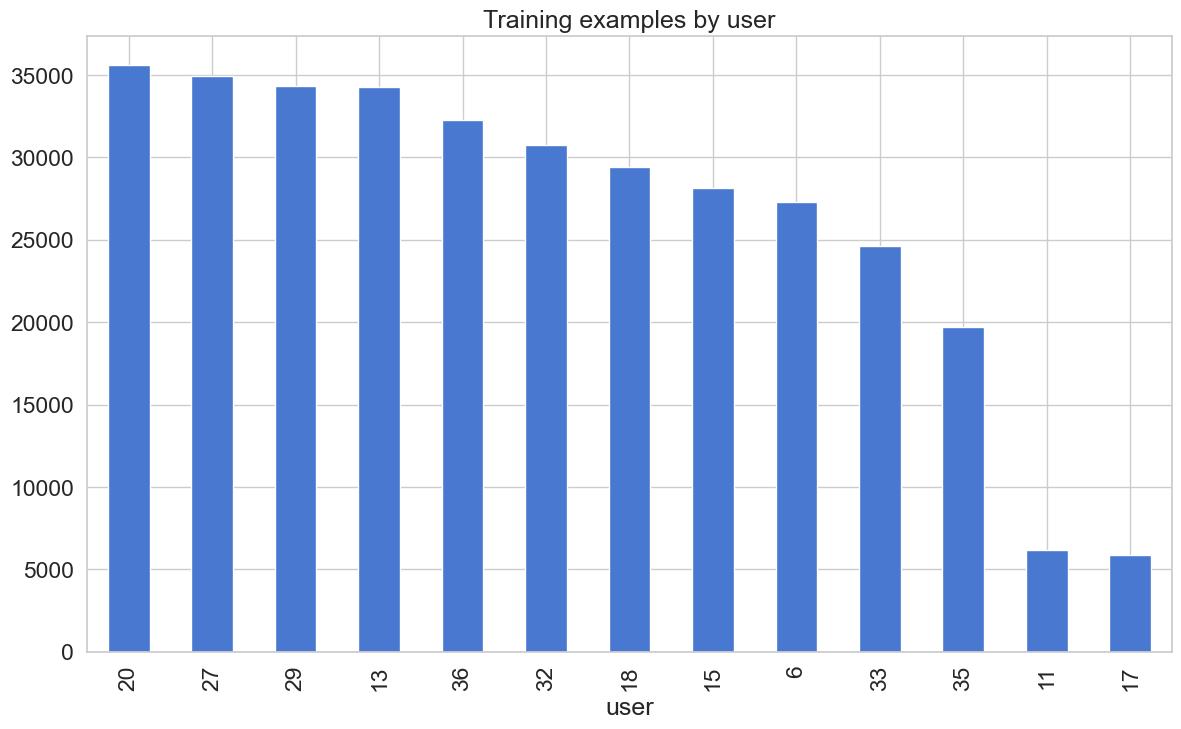

In [8]:
df['user'].value_counts().plot(kind='bar', title='Training examples by user');

I wonder whether or not number 4 received the same paycheck as number 20. Now, for some accelerometer data:

In [9]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x-axis', 'y-axis', 'z-axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12),
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

In [10]:
#print(df[['x-axis', 'y-axis', 'z-axis']].head())
#print(df[['x-axis', 'y-axis', 'z-axis']].isnull().sum())
#df[['x-axis', 'y-axis', 'z-axis']] = df[['x-axis', 'y-axis', 'z-axis']].apply(pd.to_numeric, errors='coerce')
#print(df[['x-axis', 'y-axis', 'z-axis']].isnull().sum())

In [11]:
#print(df[['x-axis', 'y-axis', 'z-axis']].dtypes)
#print(df[['x-axis', 'y-axis', 'z-axis']].head())
#print(df[['x-axis', 'y-axis', 'z-axis']].isnull().sum())
#df[['x-axis', 'y-axis', 'z-axis']] = df[['x-axis', 'y-axis', 'z-axis']].apply(pd.to_numeric, errors='coerce')
#print(df[['x-axis', 'y-axis', 'z-axis']].isnull().sum())

In [12]:
print(df.info())  # Check data types and non-null counts
print(df.describe())  # Summary statistics for numeric columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user       343416 non-null  object
 1   activity   343416 non-null  object
 2   timestamp  343416 non-null  object
 3   x-axis     343416 non-null  object
 4   y-axis     343416 non-null  object
 5   z-axis     343416 non-null  object
dtypes: object(6)
memory usage: 15.7+ MB
None
          user activity timestamp  x-axis  y-axis  z-axis
count   343416   343416    343416  343416  343416  343416
unique      13        6    303353    1755    1800     995
top         20  Walking         0       0       0     0.0
freq     35599   137375     12826   13880   13052   12823


In [13]:
# Check data types
print(df[['x-axis', 'y-axis', 'z-axis']].dtypes)

# Check for empty data
print(df[['x-axis', 'y-axis', 'z-axis']].head())

# Check for missing values
print(df[['x-axis', 'y-axis', 'z-axis']].isnull().sum())

# Convert data types to numeric if needed
df[['x-axis', 'y-axis', 'z-axis']] = df[['x-axis', 'y-axis', 'z-axis']].apply(pd.to_numeric, errors='coerce')

# Check again for missing values after conversion
print(df[['x-axis', 'y-axis', 'z-axis']].isnull().sum())

x-axis    object
y-axis    object
z-axis    object
dtype: object
        x-axis     y-axis       z-axis
0   -0.6946377  12.680544   0.50395286
1     5.012288  11.264028   0.95342433
2     4.903325  10.882658  -0.08172209
3  -0.61291564  18.496431    3.0237172
4   -1.1849703  12.108489     7.205164
x-axis    0
y-axis    0
z-axis    0
dtype: int64
x-axis    0
y-axis    0
z-axis    0
dtype: int64


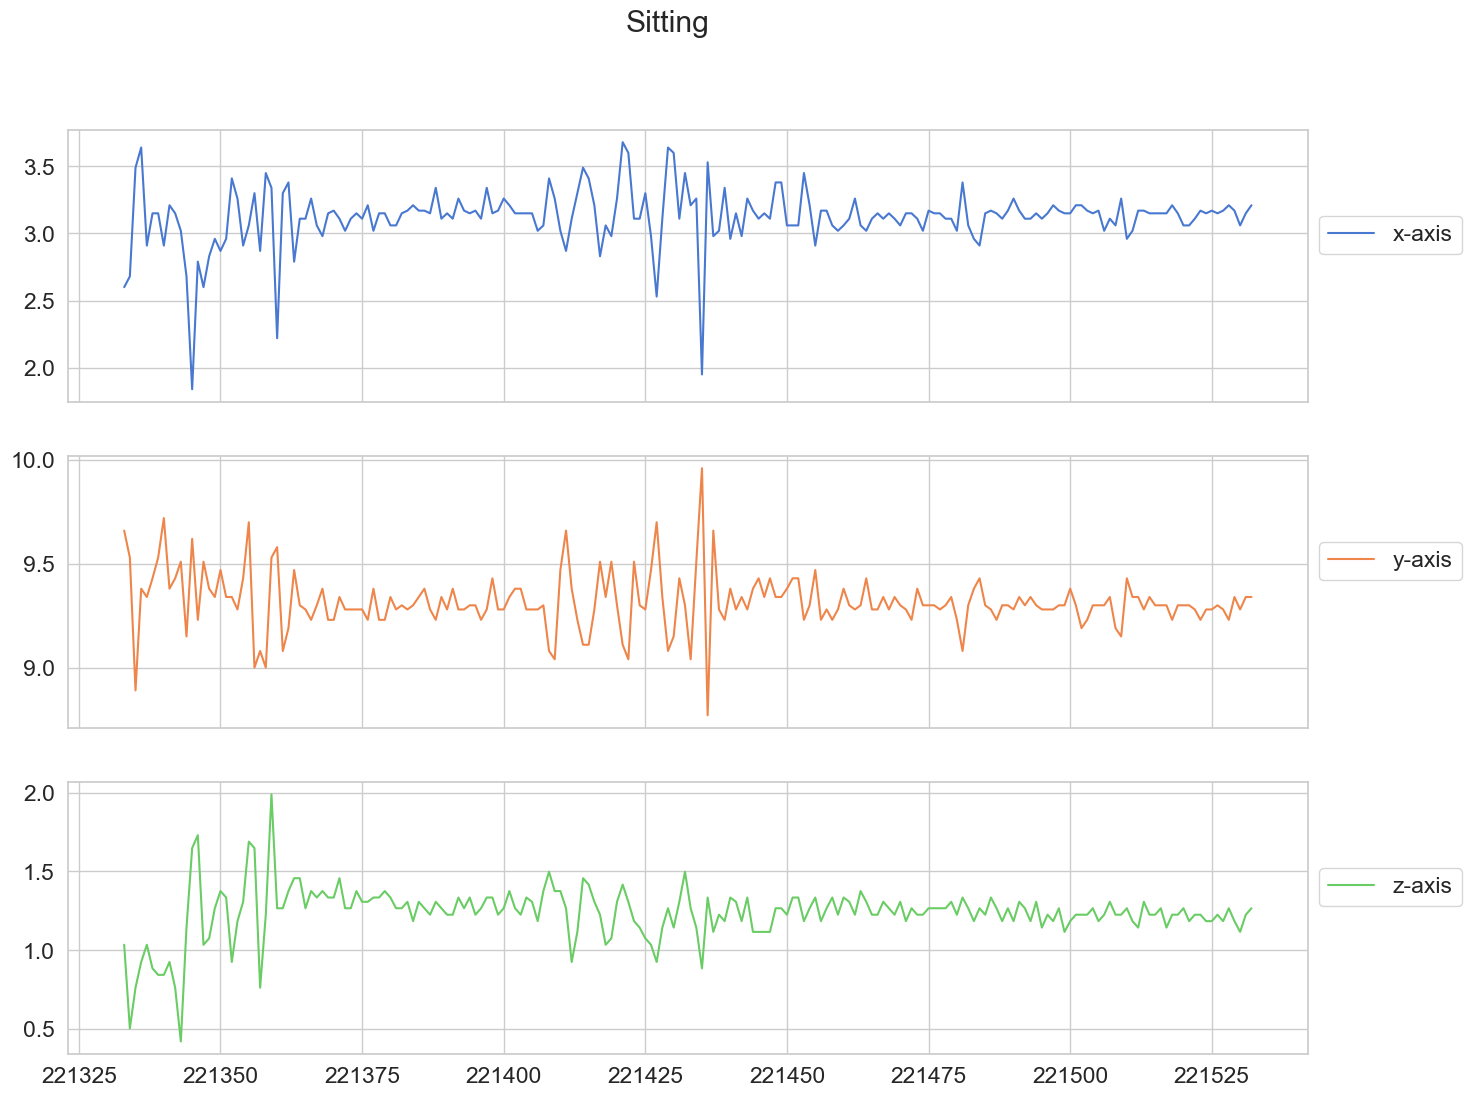

In [14]:
plot_activity("Sitting", df)

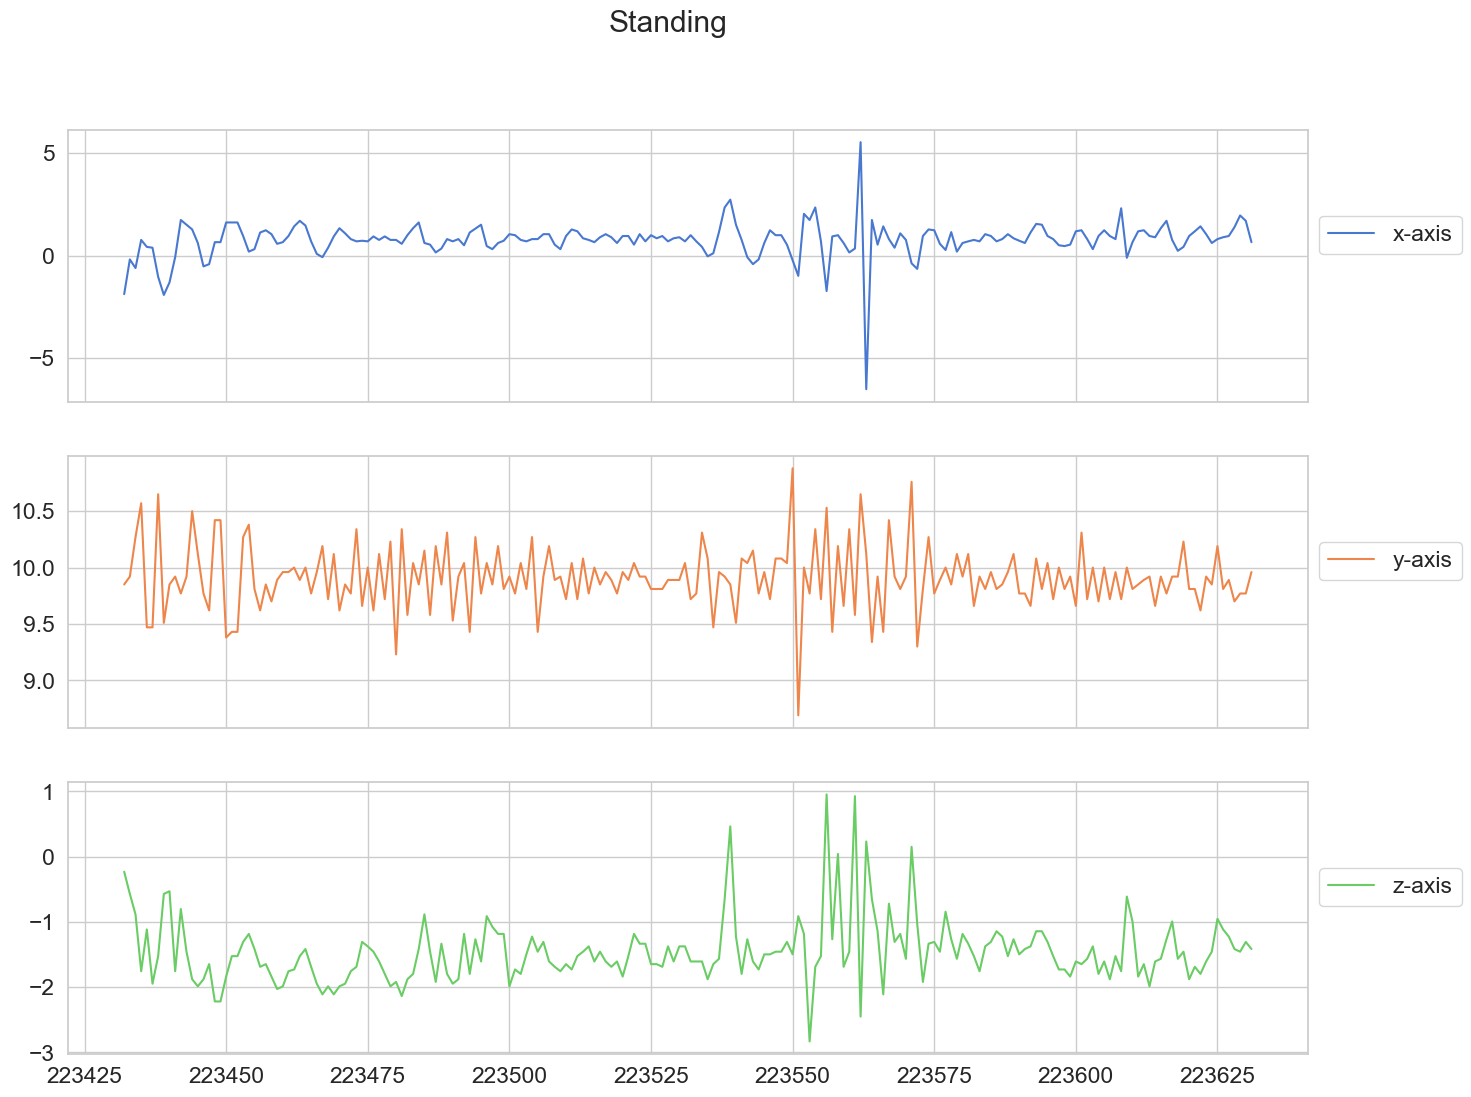

In [15]:
plot_activity("Standing", df)

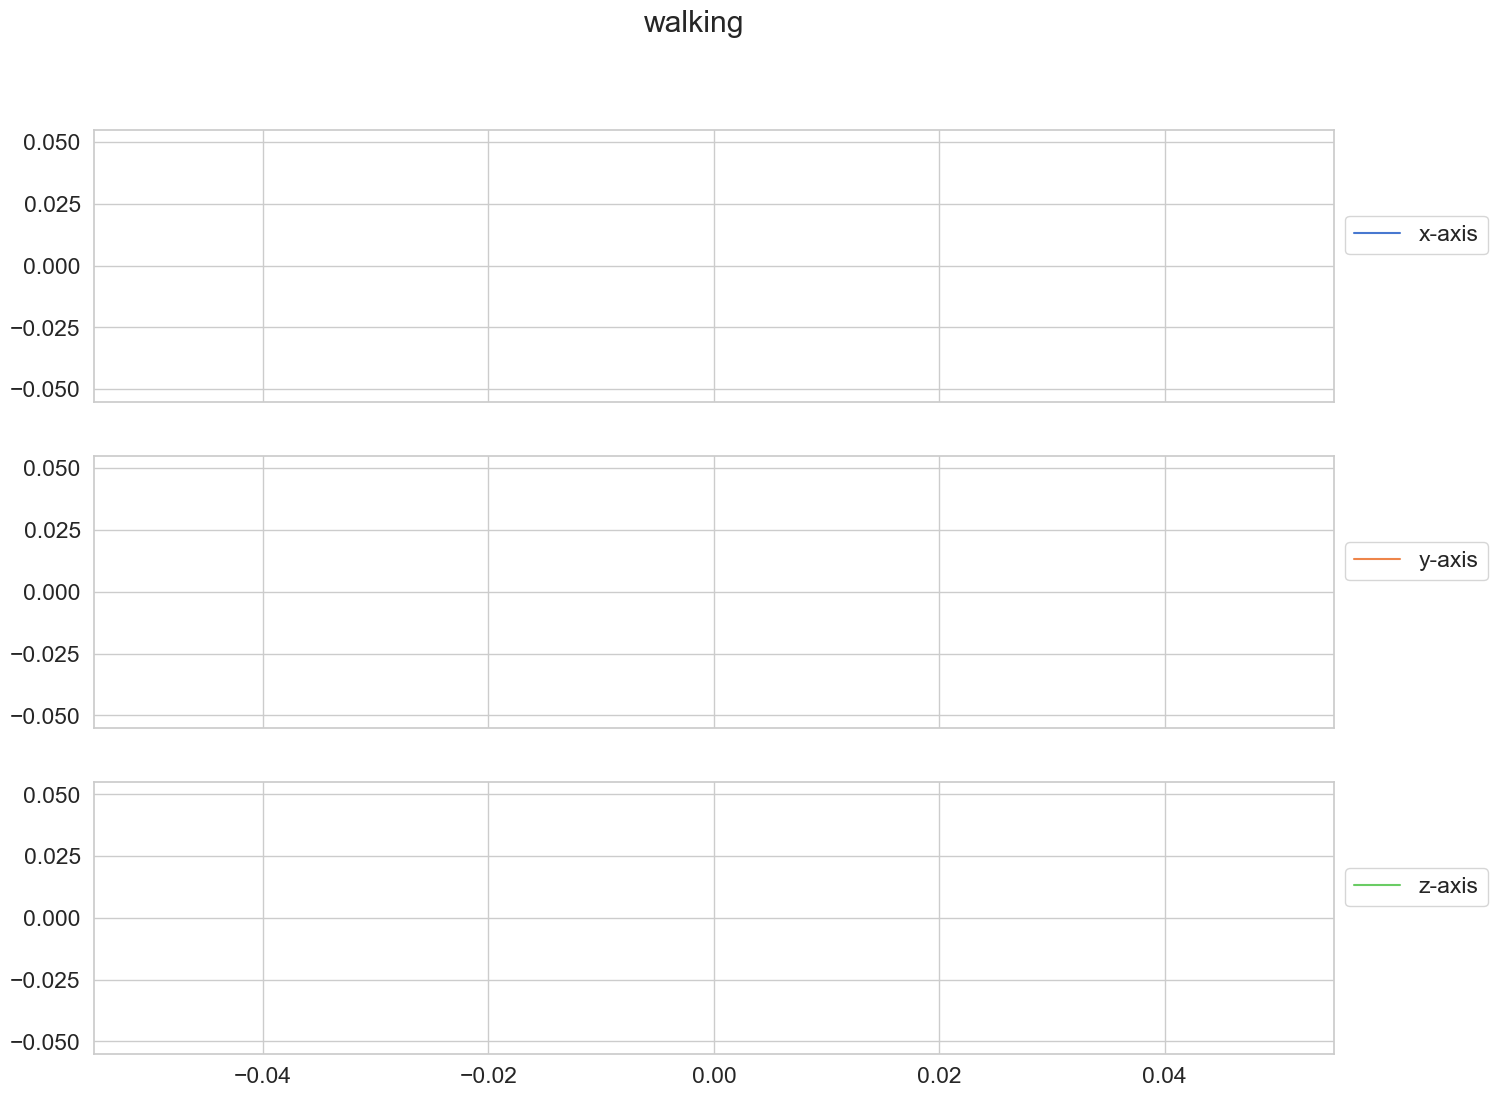

In [16]:
plot_activity("walking", df)

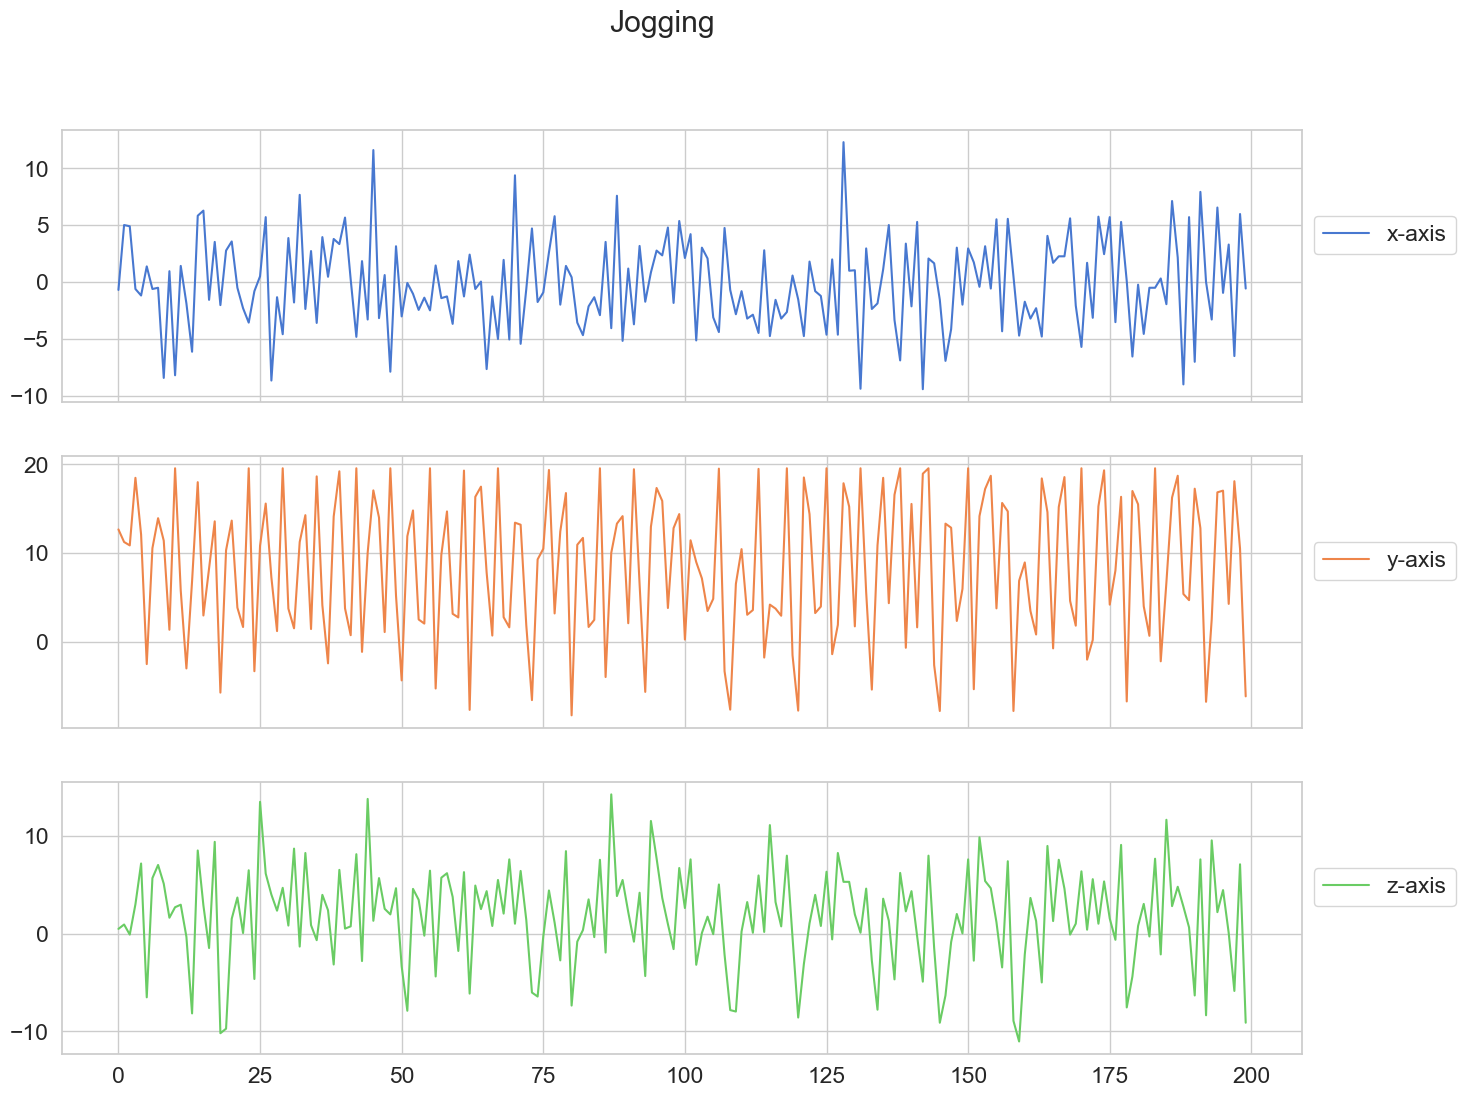

In [17]:
plot_activity("Jogging", df)

It seems reasonable to assume that this data might be used to train a model that can distinguish between the different kinds of activities. Well, at least the first 200 entries of each activity look that way.

# Data preprocessing

Our LSTM (covered in the previous part of the series) model expects fixed-length sequences as training data. We'll use a familiar method for generating these. Each generated sequence contains 200 training examples:

In [18]:
N_TIME_STEPS = 100

In [19]:
import pandas as pd
from collections import Counter
import numpy as np

# Create a sample DataFrame
data = {
    'x-axis': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'y-axis': [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'z-axis': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'activity': ['Walking', 'Walking', 'Sitting', 'Sitting', 'Walking', 'Walking', 'Standing', 'Standing']
}
df = pd.DataFrame(data)

# Parameters
N_TIME_STEPS = 3
step = 1

segments = []
labels = []

# Process data
for i in range(0, len(df) - N_TIME_STEPS + 1, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    segment = [xs, ys, zs]
    
    # Determine the most frequent activity
    activity_slice = df['activity'][i: i + N_TIME_STEPS]
    label = Counter(activity_slice).most_common(1)[0][0]
    
    segments.append(segment)
    labels.append(label)

# Print results
print(f"Segments: {segments}")
print(f"Labels: {labels}")

# Check if labels array is still empty
if len(labels) == 0:
    print("Labels array is empty. Check your data preprocessing logic.")
else:
    print("First label:", labels[0])


Segments: [[array([0.1, 0.2, 0.3]), array([0.2, 0.3, 0.4]), array([0.3, 0.4, 0.5])], [array([0.2, 0.3, 0.4]), array([0.3, 0.4, 0.5]), array([0.4, 0.5, 0.6])], [array([0.3, 0.4, 0.5]), array([0.4, 0.5, 0.6]), array([0.5, 0.6, 0.7])], [array([0.4, 0.5, 0.6]), array([0.5, 0.6, 0.7]), array([0.6, 0.7, 0.8])], [array([0.5, 0.6, 0.7]), array([0.6, 0.7, 0.8]), array([0.7, 0.8, 0.9])], [array([0.6, 0.7, 0.8]), array([0.7, 0.8, 0.9]), array([0.8, 0.9, 1. ])]]
Labels: ['Walking', 'Sitting', 'Sitting', 'Walking', 'Walking', 'Standing']
First label: Walking


In [20]:
N_TIME_STEPS = 200
N_FEATURES = 3
step = 20
segments = []
labels = []
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    segments.append([xs, ys, zs])
    labels.append(label)

In [21]:
np.array(segments).shape

(0,)

Our training dataset has drastically reduced size after the transformation. Note that we take the most common activity and assign it as a label for the sequence.

The shape of our tensor looks kinda strange. Let's transform it into sequences of 200 rows, each containing x, y and z. Let's apply a one-hot encoding to our labels, as well:

In [22]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [23]:
reshaped_segments.shape

(0, 200, 3)

In [25]:
labels[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

Finally, let's split the data into training and test (20%) set:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming reshaped_segments and labels are generated from previous steps

# Check lengths of the lists
print(f"Length of reshaped_segments: {len(reshaped_segments)}")
print(f"Length of labels: {len(labels)}")

# Print sample data
if len(reshaped_segments) > 0 and len(labels) > 0:
    print("Sample reshaped_segment:", reshaped_segments[0])
    print("Sample label:", labels[0])
else:
    print("Error: reshaped_segments or labels are empty. Check your data preprocessing logic.")

# Proceed with train_test_split only if lists are not empty
if len(reshaped_segments) > 0 and len(labels) > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=42
    )
    print(f"Shape of X_train: {np.array(X_train).shape}")
    print(f"Shape of X_test: {np.array(X_test).shape}")
    print(f"Shape of y_train: {np.array(y_train).shape}")
    print(f"Shape of y_test: {np.array(y_test).shape}")
else:
    print("Error: Cannot split empty lists.")


Length of reshaped_segments: 0
Length of labels: 0
Error: reshaped_segments or labels are empty. Check your data preprocessing logic.
Error: Cannot split empty lists.


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame
# Ensure your DataFrame df is loaded correctly
print(df.head())
print(df.info())

# Define constants
N_TIME_STEPS = 200
N_FEATURES = 3
step = 1

# Initialize lists to hold segments and labels
segments = []
labels = []

# Loop through the DataFrame to create segments and corresponding labels
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    
    # Use mode to determine the label for the segment
    label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
    
    # Append the segment and label
    segments.append([xs, ys, zs])
    labels.append(label)

# Reshape the segments for model input
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(labels)

# Check the resulting arrays
print(f"Length of reshaped_segments: {len(reshaped_segments)}")
print(f"Length of labels: {len(labels)}")

# Print sample data if available
if len(reshaped_segments) > 0 and len(labels) > 0:
    print("Sample reshaped_segment shape:", reshaped_segments[0].shape)
    print("Sample label:", labels[0])
else:
    print("Error: reshaped_segments or labels are empty. Check your data preprocessing logic.")

# Proceed with train_test_split only if lists are not empty
if len(reshaped_segments) > 0 and len(labels) > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=42
    )
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of y_test: {y_test.shape}")
else:
    print("Error: Cannot split empty lists.")


   x-axis  y-axis  z-axis activity
0     0.1     0.2     0.3  Walking
1     0.2     0.3     0.4  Walking
2     0.3     0.4     0.5  Sitting
3     0.4     0.5     0.6  Sitting
4     0.5     0.6     0.7  Walking
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x-axis    8 non-null      float64
 1   y-axis    8 non-null      float64
 2   z-axis    8 non-null      float64
 3   activity  8 non-null      object 
dtypes: float64(3), object(1)
memory usage: 384.0+ bytes
None
Length of reshaped_segments: 0
Length of labels: 0
Error: reshaped_segments or labels are empty. Check your data preprocessing logic.
Error: Cannot split empty lists.


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split

N_TIME_STEPS = 200
N_FEATURES = 3
RANDOM_SEED = 42

# Assuming df is your dataframe with the sensor data and 'activity' column

def create_segments_and_labels(df, time_steps, step):
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        label = stats.mode(df['activity'][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)
    return reshaped_segments, labels

# Create segments and labels
reshaped_segments, labels = create_segments_and_labels(df, N_TIME_STEPS, step=20)

# Debug prints to check data
print(f"reshaped_segments shape: {reshaped_segments.shape}")
print(f"labels shape: {labels.shape}")

# Ensure the data is not empty
if reshaped_segments.size == 0 or labels.size == 0:
    raise ValueError("The segmented data or labels are empty. Please check your data preprocessing steps.")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED
)

# Debug prints to check splits
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


reshaped_segments shape: (0, 200, 3)
labels shape: (0,)


ValueError: The segmented data or labels are empty. Please check your data preprocessing steps.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    reshaped_segments, labels, test_size=0.2, random_state=RANDOM_SEED)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and it's already loaded
# Print the first few rows and info of the DataFrame to ensure it's correctly loaded
print(df.head())
print(df.info())

# Define constants
N_TIME_STEPS = 200
N_FEATURES = 3
step = 1

# Initialize lists to hold segments and labels
segments = []
labels = []

# Loop through the DataFrame to create segments and corresponding labels
for i in range(0, len(df) - N_TIME_STEPS, step):
    xs = df['x-axis'].values[i: i + N_TIME_STEPS]
    ys = df['y-axis'].values[i: i + N_TIME_STEPS]
    zs = df['z-axis'].values[i: i + N_TIME_STEPS]
    
    # Use mode to determine the label for the segment
    try:
        label = stats.mode(df['activity'][i: i + N_TIME_STEPS])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    except Exception as e:
        print(f"Error processing segment {i}: {e}")
        continue

# Convert segments and labels to NumPy arrays and reshape segments for model input
reshaped_segments = np.asarray(segments, dtype=np.float32).reshape(-1, N_TIME_STEPS, N_FEATURES)
labels = np.asarray(labels)

# Check the resulting arrays
print(f"Length of reshaped_segments: {len(reshaped_segments)}")
print(f"Length of labels: {len(labels)}")

# Print sample data if available
if len(reshaped_segments) > 0 and len(labels) > 0:
    print("Sample reshaped_segment shape:", reshaped_segments[0].shape)
    print("Sample label:", labels[0])
else:
    print("Error: reshaped_segments or labels are empty. Check your data preprocessing logic.")

# Proceed with train_test_split only if lists are not empty
if len(reshaped_segments) > 0 and len(labels) > 0:
    X_train, X_test, y_train, y_test = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=42
    )
    print(f"Shape of X_train: {X_train.shape}")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Shape of y_train: {y_train.shape}")
    print(f"Shape of y_test: {y_test.shape}")
else:
    print("Error: Cannot split empty lists.")


   x-axis  y-axis  z-axis activity
0     0.1     0.2     0.3  Walking
1     0.2     0.3     0.4  Walking
2     0.3     0.4     0.5  Sitting
3     0.4     0.5     0.6  Sitting
4     0.5     0.6     0.7  Walking
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   x-axis    8 non-null      float64
 1   y-axis    8 non-null      float64
 2   z-axis    8 non-null      float64
 3   activity  8 non-null      object 
dtypes: float64(3), object(1)
memory usage: 384.0+ bytes
None
Length of reshaped_segments: 0
Length of labels: 0
Error: reshaped_segments or labels are empty. Check your data preprocessing logic.
Error: Cannot split empty lists.


In [ ]:
len(X_train)

NameError: name 'X_train' is not defined

In [27]:
len(X_test)

NameError: name 'X_test' is not defined

# Building the model

Our model contains 2 fully-connected and 2 LSTM layers (stacked on each other) with 64 units each:

In [ ]:
N_CLASSES = 6
N_HIDDEN_UNITS = 64

In [ ]:
def create_LSTM_model(inputs):
    W = {
        'hidden': tf.Variable(tf.random_normal([N_FEATURES, N_HIDDEN_UNITS])),
        'output': tf.Variable(tf.random_normal([N_HIDDEN_UNITS, N_CLASSES]))
    }
    biases = {
        'hidden': tf.Variable(tf.random_normal([N_HIDDEN_UNITS], mean=1.0)),
        'output': tf.Variable(tf.random_normal([N_CLASSES]))
    }

    X = tf.transpose(inputs, [1, 0, 2])
    X = tf.reshape(X, [-1, N_FEATURES])
    hidden = tf.nn.relu(tf.matmul(X, W['hidden']) + biases['hidden'])
    hidden = tf.split(hidden, N_TIME_STEPS, 0)

    # Stack 2 LSTM layers
    lstm_layers = [tf.contrib.rnn.BasicLSTMCell(N_HIDDEN_UNITS, forget_bias=1.0) for _ in range(2)]
    lstm_layers = tf.contrib.rnn.MultiRNNCell(lstm_layers)

    outputs, _ = tf.contrib.rnn.static_rnn(lstm_layers, hidden, dtype=tf.float32)

    # Get output for the last time step
    lstm_last_output = outputs[-1]

    return tf.matmul(lstm_last_output, W['output']) + biases['output']

Now, let create placeholders for our model:

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, N_TIME_STEPS, N_FEATURES], name="input")
Y = tf.placeholder(tf.float32, [None, N_CLASSES])

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

Note that we named the input tensor, that will be useful when using the model from Android. Creating the model:

In [ ]:
pred_Y = create_LSTM_model(X)

pred_softmax = tf.nn.softmax(pred_Y, name="y_")

NameError: name 'X' is not defined

Again, we must properly name the tensor from which we will obtain predictions. We will use L2 regularization and that must be noted in our loss op:

In [ ]:
L2_LOSS = 0.0015

l2 = L2_LOSS * \
    sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables())

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = pred_Y, labels = Y)) + l2

AttributeError: module 'tensorflow' has no attribute 'trainable_variables'

Finally, let's define optimizer and accuracy ops:

In [ ]:
LEARNING_RATE = 0.0025

optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss)

correct_pred = tf.equal(tf.argmax(pred_softmax, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'AdamOptimizer'

# Training

The training part contains a lot of TensorFlow boilerplate. We will train our model for 50 epochs and keep track of accuracy and error:

In [ ]:
N_EPOCHS = 50
BATCH_SIZE = 1024

In [ ]:
saver = tf.train.Saver()

history = dict(train_loss=[],
                     train_acc=[],
                     test_loss=[],
                     test_acc=[])

sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

train_count = len(X_train)

for i in range(1, N_EPOCHS + 1):
    for start, end in zip(range(0, train_count, BATCH_SIZE),
                          range(BATCH_SIZE, train_count + 1,BATCH_SIZE)):
        sess.run(optimizer, feed_dict={X: X_train[start:end],
                                       Y: y_train[start:end]})

    _, acc_train, loss_train = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_train, Y: y_train})

    _, acc_test, loss_test = sess.run([pred_softmax, accuracy, loss], feed_dict={
                                            X: X_test, Y: y_test})

    history['train_loss'].append(loss_train)
    history['train_acc'].append(acc_train)
    history['test_loss'].append(loss_test)
    history['test_acc'].append(acc_test)

    if i != 1 and i % 10 != 0:
        continue

    print(f'epoch: {i} test accuracy: {acc_test} loss: {loss_test}')

predictions, acc_final, loss_final = sess.run([pred_softmax, accuracy, loss], feed_dict={X: X_test, Y: y_test})

print()
print(f'final results: accuracy: {acc_final} loss: {loss_final}')

AttributeError: module 'tensorflow._api.v2.train' has no attribute 'Saver'

Whew, that was a lot of training. Do you feel thirsty? Let's store our precious model to disk:

In [ ]:
pickle.dump(predictions, open("predictions.p", "wb"))
pickle.dump(history, open("history.p", "wb"))
tf.train.write_graph(sess.graph_def, '.', './checkpoint/har.pbtxt')
saver.save(sess, save_path = "./checkpoint/har.ckpt")
sess.close()

And loading it back:

In [ ]:
history = pickle.load(open("history.p", "rb"))
predictions = pickle.load(open("predictions.p", "rb"))

# Evaluation

In [ ]:
plt.figure(figsize=(12, 8))

plt.plot(np.array(history['train_loss']), "r--", label="Train loss")
plt.plot(np.array(history['train_acc']), "g--", label="Train accuracy")

plt.plot(np.array(history['test_loss']), "r-", label="Test loss")
plt.plot(np.array(history['test_acc']), "g-", label="Test accuracy")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training Epoch')
plt.ylim(0)

plt.show()

NameError: name 'history' is not defined

<Figure size 1200x800 with 0 Axes>

Our model seems to learn well with accuracy reaching above 97% and loss hovering at around 0.2. Let's have a look at the confusion matrix for the model's predictions:

In [ ]:
LABELS = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']

In [ ]:
max_test = np.argmax(y_test, axis=1)
max_predictions = np.argmax(predictions, axis=1)
confusion_matrix = metrics.confusion_matrix(max_test, max_predictions)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

NameError: name 'y_test' is not defined


# Exporting the model

In [ ]:
from tensorflow.python.tools import freeze_graph

MODEL_NAME = 'har'

input_graph_path = 'checkpoint/' + MODEL_NAME+'.pbtxt'
checkpoint_path = './checkpoint/' +MODEL_NAME+'.ckpt'
restore_op_name = "save/restore_all"
filename_tensor_name = "save/Const:0"
output_frozen_graph_name = 'frozen_'+MODEL_NAME+'.pb'

freeze_graph.freeze_graph(input_graph_path, input_saver="",
                          input_binary=False, input_checkpoint=checkpoint_path,
                          output_node_names="y_", restore_op_name="save/restore_all",
                          filename_tensor_name="save/Const:0",
                          output_graph=output_frozen_graph_name, clear_devices=True, initializer_nodes="")

INFO:tensorflow:Restoring parameters from ./checkpoint/har.ckpt
INFO:tensorflow:Froze 8 variables.
Converted 8 variables to const ops.
6862 ops in the final graph.
